In [1]:
import numpy as np
import shapely
import shapely.geometry
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rasterio.windows  as rw
from rasterio.enums import Resampling
from rasterio.transform import Affine
from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import gmean
from scipy.optimize import minimize
from typing import List, Any
import os
import pandas as pd
import seaborn as sns

In [2]:
import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd

settings18 = sgl.ProcessorSGLSettings.from_range("20181201", "20190331")
sgl.initialize(settings18)
metas18 = sgl.get_metadata_from_csv(settings18.season_folder, ["tile-181", "tile-182", "tile-183"])
coll18 = sgl.create_collection_from_meta(settings18, metas18)

settings19 = sgl.ProcessorSGLSettings.from_range("20191201", "20200331")
sgl.initialize(settings19)
metas19 = sgl.get_metadata_from_csv(settings19.season_folder, ["tile-181", "tile-182", "tile-183"])
coll19 = sgl.create_collection_from_meta(settings19, metas19)

settings20 = sgl.ProcessorSGLSettings.from_range("20201201", "20210331")
sgl.initialize(settings20)
metas20 = sgl.get_metadata_from_csv(settings20.season_folder, ["tile-181", "tile-182", "tile-183"])
coll20 = sgl.create_collection_from_meta(settings20, metas20)

X=====================================================
SGLProcessor started for 20181201 to 20190331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.
X=====================================================
SGLProcessor started for 20201201 to 20210331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.


In [3]:
lakeextent18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_lakeextent.shp"))
drains18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_drain.shp"))
gdf_labels18 = pd.read_excel(os.path.join(settings18.season_folder, "drain_labels_v1.xlsx"))
drain_labels18 = dict(zip(gdf_labels18[gdf_labels18["window"] == 0]["criteria"], gdf_labels18[gdf_labels18["window"] == 0]["drainage"]))
positive_drains18 = [k for k, v in drain_labels18.items() if v == 1]
crevs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "crev_20181201_20190331_active_45(15).shp"))
dmgs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "S1_20181201_20190331_dmg_10.shp"))

In [4]:
lakeextent19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_lakeextent.shp"))
drains19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_drain.shp"))
gdf_labels19 = pd.read_excel(os.path.join(settings19.season_folder, "drain_labels_v1.xlsx"))
drain_labels19 = dict(zip(gdf_labels19[gdf_labels19["window"] == 0]["criteria"], gdf_labels19[gdf_labels19["window"] == 0]["drainage"]))
positive_drains19 = [k for k, v in drain_labels19.items() if v == 1]
crevs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "crev_20191201_20200331_active_45(15).shp"))
dmgs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "S1_20191201_20200331_dmg_10.shp"))

In [5]:
lakeextent20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_lakeextent.shp"))
drains20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_drain.shp"))
gdf_labels20 = pd.read_excel(os.path.join(settings20.season_folder, "drain_labels_v1.xlsx"))
drain_labels20 = dict(zip(gdf_labels20[gdf_labels20["window"] == 0]["criteria"], gdf_labels20[gdf_labels20["window"] == 0]["drainage"]))
positive_drains20 = [k for k, v in drain_labels20.items() if v == 1]
crevs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "crev_20201201_20210331_active_45(15).shp"))
dmgs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "S1_20201201_20210331_dmg_10.shp"))

In [6]:
lakeextent = lakeextent19
lakeextent["area"] = lakeextent.area
lakeextent_filtered = lakeextent[lakeextent["area"] >= 0.054 * 1e6]

In [7]:
coll = coll19
settings = settings19
drains = pd.concat([drains18, drains19, drains20])
drains.set_crs(drains18.crs)
target_res = 3e3

In [8]:
def get_value(row, src):
    center = row["geometry"].centroid
    return [v for v in src.sample([(center.x, center.y)])][0][0]

In [12]:
dmg_file = f"shackleton_{coll.rangestart}_{coll.rangeend}_{int(target_res)}m_dmg.tif"
with rasterio.open(os.path.join(settings.dmg_folder, dmg_file)) as src:
    drains["dmg"] = drains.apply(get_value, axis = 1,src = src)

crev_file = f"shackleton_{coll.rangestart}_{coll.rangeend}_{int(target_res)}m_crev.tif"
with rasterio.open(os.path.join(settings.dmg_folder, crev_file)) as src:
    drains["crev"] = drains.apply(get_value, axis = 1,src = src)

emax_file = f"shackleton_{int(target_res)}m_emax.tif"
with rasterio.open(os.path.join(settings.region_folder, emax_file)) as src:
    drains["emax"] = drains.apply(get_value, axis = 1,src = src)

In [43]:
def get_weakness(row, exponents):
    return row["dmg"]**exponents[0] * row["crev"]**exponents[1] * row["emax"]**exponents[2]

In [44]:
def get_weakness(row, exponents):
    return row["dmg"]**exponents[0] * row["crev"]**exponents[1] * row["emax"]**exponents[2]
def fun(x, drains):
    return -1 * drains.apply(get_weakness, axis = 1, exponents = x).mean(skipna = True)

In [47]:
x0 = np.array([0, 0, 0])
res = minimize(fun, x0, args = (drains), bounds = [(1, 10)])
res

C:\Users\js-ms\AppData\Local\Temp\ipykernel_28612\2884048880.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return row["dmg"]**exponents[0] * row["crev"]**exponents[1] * row["emax"]**exponents[2]
C:\Users\js-ms\AppData\Local\Temp\ipykernel_28612\2884048880.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return row["dmg"]**exponents[0] * row["crev"]**exponents[1] * row["emax"]**exponents[2]
C:\Users\js-ms\AppData\Local\Temp\ipykernel_28612\2884048880.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return row["dmg"]**exponents[0] * row["crev"]**exponents[1] * row["emax"]**exponents[2]
C:\Users\js-ms\AppData\Local\Temp\ipykernel_28612\2884048880.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return row["dmg"]**exponents[0] * row["crev"]**exponents[1] * row["emax"]**exponents[2]
C:\Users\js-ms\AppData\Local\Temp\ipykernel_28612\2884048880.py:2: RuntimeWarning: invalid value encountered in double_scalars
  ret

      fun: -0.00033973434538347167
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00129427, 0.00038004, 0.00077659])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 1
     njev: 15
   status: 0
  success: True
        x: array([1.        , 1.        , 1.00000559])

In [100]:
lakeextent = lakeextent19
lakeextent["area"] = lakeextent.area
lakeextent_filtered = lakeextent[lakeextent["area"] >= 0.054 * 1e6]
lakeextent_filtered["category"] = "lake"
drains["category"] = "drain"
combined = pd.concat([lakeextent_filtered, drains[drains["window"] == 0]], ignore_index = True)
combined.shape

d:\Programme\Anaconda\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


(886, 23)

In [27]:
def calculate_fraction_active_dmg(row, activeness_list, offset: float = 1e3):
    activeness_filtered = [a for a in activeness_list if a["name"] == row["name"]]
    if len(activeness_filtered) == 0:
        return None
    a = activeness_filtered[0]
    center = row["geometry"].centroid
    minx = center.x - offset
    miny = center.y - offset
    maxx = center.x + offset
    maxy = center.y + offset

    dmg_w = sgl_utils.window_dataset(a["dmg"], a["dmg transform"], minx, miny, maxx, maxy)[0]
    dmg_mask = np.zeros(dmg_w.shape)
    dmg_mask[dmg_w > 0] = 1

    delta_alpha_c_w = sgl_utils.window_dataset(a["delta alpha c"], a["delta alpha c transform"], minx, miny, maxx, maxy)[0]
    active_crev = sgl_utils.create_active_crevasses_mask(delta_alpha_c_w, 45, 15) * dmg_mask

    amount_active = active_crev[active_crev >= 0].size
    amount_dmg = dmg_w[dmg_w >= 0].size
    
    if (amount_active == 0) or (amount_dmg == 0):
        return 0
    return amount_active / amount_dmg

def calculate_sum_dmg(row, activeness_list, offset: float = 1e3):
    activeness_filtered = [a for a in activeness_list if a["name"] == row["name"]]
    if len(activeness_filtered) == 0:
        return None
    a = activeness_filtered[0]
    center = row["geometry"].centroid
    minx = center.x - offset
    miny = center.y - offset
    maxx = center.x + offset
    maxy = center.y + offset

    #emax_w = sgl_utils.window_dataset(a["emax"], a["emax transform"], minx, miny, maxx, maxy)[0]

    dmg_w = sgl_utils.window_dataset(a["dmg"], a["dmg transform"], minx, miny, maxx, maxy)[0]
    dmg_mask = np.zeros(dmg_w.shape)
    dmg_mask[dmg_w > 0] = 1

    delta_alpha_c_w = sgl_utils.window_dataset(a["delta alpha c"], a["delta alpha c transform"], minx, miny, maxx, maxy)[0]
    #active_crev = sgl_utils.create_active_crevasses_mask(delta_alpha_c_w, 45, 15) * dmg_mask

    sum_dmg = np.nan_to_num(dmg_w, nan = 0).sum()

    return sum_dmg

def calculate_strain(row, activeness_list, offset: float = 1e3):
    activeness_filtered = [a for a in activeness_list if a["name"] == row["name"]]
    if len(activeness_filtered) == 0:
        return None
    a = activeness_filtered[0]
    center = row["geometry"].centroid
    minx = center.x - offset
    miny = center.y - offset
    maxx = center.x + offset
    maxy = center.y + offset

    emax_w = sgl_utils.window_dataset(a["emax"], a["emax transform"], minx, miny, maxx, maxy)[0]

    return np.mean(emax_w)

def calculate_dmg_distances(row, activeness_list, offset: float = 1e3, cat: float = 1):
    activeness_filtered = [a for a in activeness_list if a["name"] == row["name"]]
    if len(activeness_filtered) == 0:
        return None
    a = activeness_filtered[0]
    center = row["geometry"].centroid
    minx = center.x - offset
    miny = center.y - offset
    maxx = center.x + offset
    maxy = center.y + offset

    dmgs_w = dmgs[dmgs["dmg"] == cat].cx[minx:maxx, miny:maxy]
    if dmgs_w.shape[0] == 0:
        return None
    gdf_distances = ckdnearest_DfromPOINT(gpd.GeoDataFrame(dmgs_w), row["geometry"].centroid)

    return gdf_distances["dist-lake-d"].mean()

def ckdnearest_DfromPOINT(gdD: gpd.GeoDataFrame, point: shapely.geometry.Point):
    gdD.reset_index(drop=True, inplace = True)
    nD = np.array(list(gdD["geometry"].centroid.apply(lambda x: (x.x, x.y))))
    nPOINT = np.array([(point.x, point.y)])
    POINTtree = cKDTree(nPOINT)
    dist, idx = POINTtree.query(nD)
    gdf = pd.concat(
        [
            gdD.reset_index(drop=True).rename(columns={"geometry" : "d-geometry"}),
            pd.Series(dist, name='dist-lake-d'),
            
        ], 
        axis=1)

    return gdf


In [12]:
def ckdnearest_SGLfromD(gdSGL, gdD, number_nearest_dmg: int = 1):
    dmg_cats = sorted(gdD["dmg"].unique())
    gdSGL = gdSGL.reset_index(drop=True)
    nSGL = np.array(list(gdSGL["geometry"].centroid.apply(lambda x: (x.x, x.y))))
    gdf_cats = []
    for cat in dmg_cats:
        gdD_cat = gdD[gdD["dmg"] == cat].reset_index(drop=True)
        nD_cat = np.array(list(gdD_cat["geometry"].centroid.apply(lambda x: (x.x, x.y))))
        Dtree = cKDTree(nD_cat)
        dist, idx = Dtree.query(nSGL, k=number_nearest_dmg)
        if idx.ndim > 1:
            gdD_cat_nearest = gdD_cat.iloc[idx[0]].rename(columns={"geometry" : "dmg-geometry"}).reset_index(drop=True)
            gdf_cat = pd.concat(
                [
                    gdSGL.reset_index(drop=True).rename(columns={"geometry" : "sgl-geometry"}),
                    pd.Series(dist.mean(axis = 1), name='dist-dmg-lake'),
                    gdD_cat_nearest
                    
                ], 
                axis=1)
        else:
            gdD_cat_nearest = gdD_cat.iloc[idx].rename(columns={"geometry" : "dmg-geometry"}).reset_index(drop=True)

            gdf_cat = pd.concat(
                [
                    gdSGL.reset_index(drop=True).rename(columns={"geometry" : "sgl-geometry"}),
                    pd.Series(dist, name='dist-dmg-lake'),
                    gdD_cat_nearest,
                    
                ], 
                axis=1)
        gdf_cats.append(gdf_cat)

    return dmg_cats, gdf_cats

In [13]:
def ckdnearest_SGLfromCREV(gdSGL, gdCREV, number_nearest_crev: int = 1):
    gdSGL = gdSGL.reset_index(drop=True)
    nSGL = np.array(list(gdSGL["geometry"].centroid.apply(lambda x: (x.x, x.y))))

    nCREV = np.array(list(gdCREV["geometry"].centroid.apply(lambda x: (x.x, x.y))))
    CREVtree = cKDTree(nCREV)
    dist, idx = CREVtree.query(nSGL, k=number_nearest_crev)
    if idx.ndim > 1:
        gdCREV_nearest = gdCREV.iloc[idx[0]].rename(columns={"geometry" : "crev-geometry"}).reset_index(drop=True)
        gdf = pd.concat(
            [
                gdSGL.reset_index(drop=True).rename(columns={"geometry" : "sgl-geometry"}),
                pd.Series(dist.mean(axis = 1), name='dist-lake-crev'),
                gdCREV_nearest
                
            ], 
            axis=1)
    else:
        gdCREV_nearest = gdCREV.iloc[idx].rename(columns={"geometry" : "crev-geometry"}).reset_index(drop=True)

        gdf = pd.concat(
            [
                gdSGL.reset_index(drop=True).rename(columns={"geometry" : "sgl-geometry"}),
                pd.Series(dist, name='dist-lake-crev'),
                gdCREV_nearest,
                
            ], 
            axis=1)

    return gdf



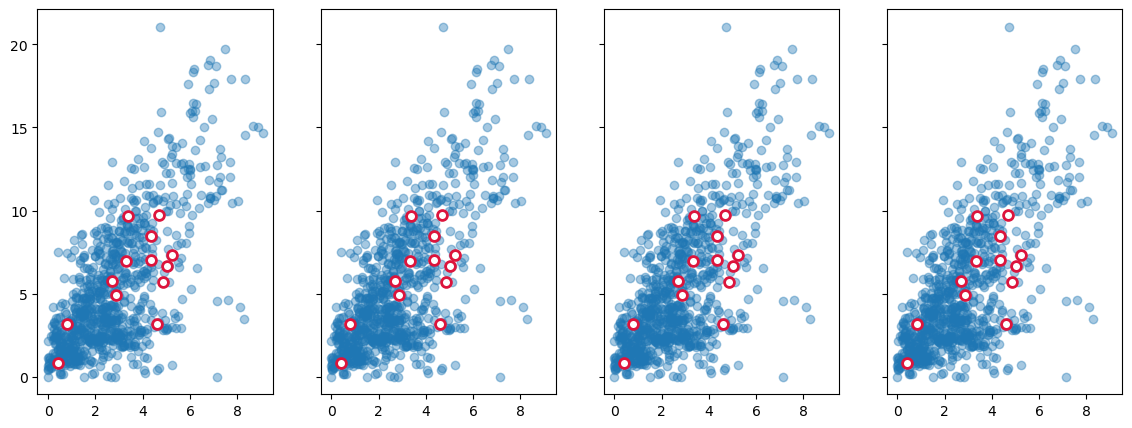

In [175]:
fig, axes = plt.subplots(1, 4, figsize = (14, 5), sharey = True)
for icat, cat in enumerate(sorted(list(set(drains_cats + lakes_cats)))):
    ax = axes[icat]
    ax.scatter(lakes_distances[icat]["sum dmg"], lakes_distances[icat]["active"], color = "tab:blue", alpha = 0.4)
    ax.scatter(drains_distances[icat][(drains_distances[icat]["window"] == 0)]["sum dmg"], drains_distances[icat][(drains_distances[icat]["window"] == 0)]["active"], c = "white", edgecolor="crimson", s = 50, lw = 2)

In [34]:
combined["fraction active * sum dmg"] = combined["dmg fraction active"] * combined["sum dmg"]
combined["fraction active * sum dmg * strain"] = combined["dmg fraction active"] * combined["sum dmg"] * combined["strain"]

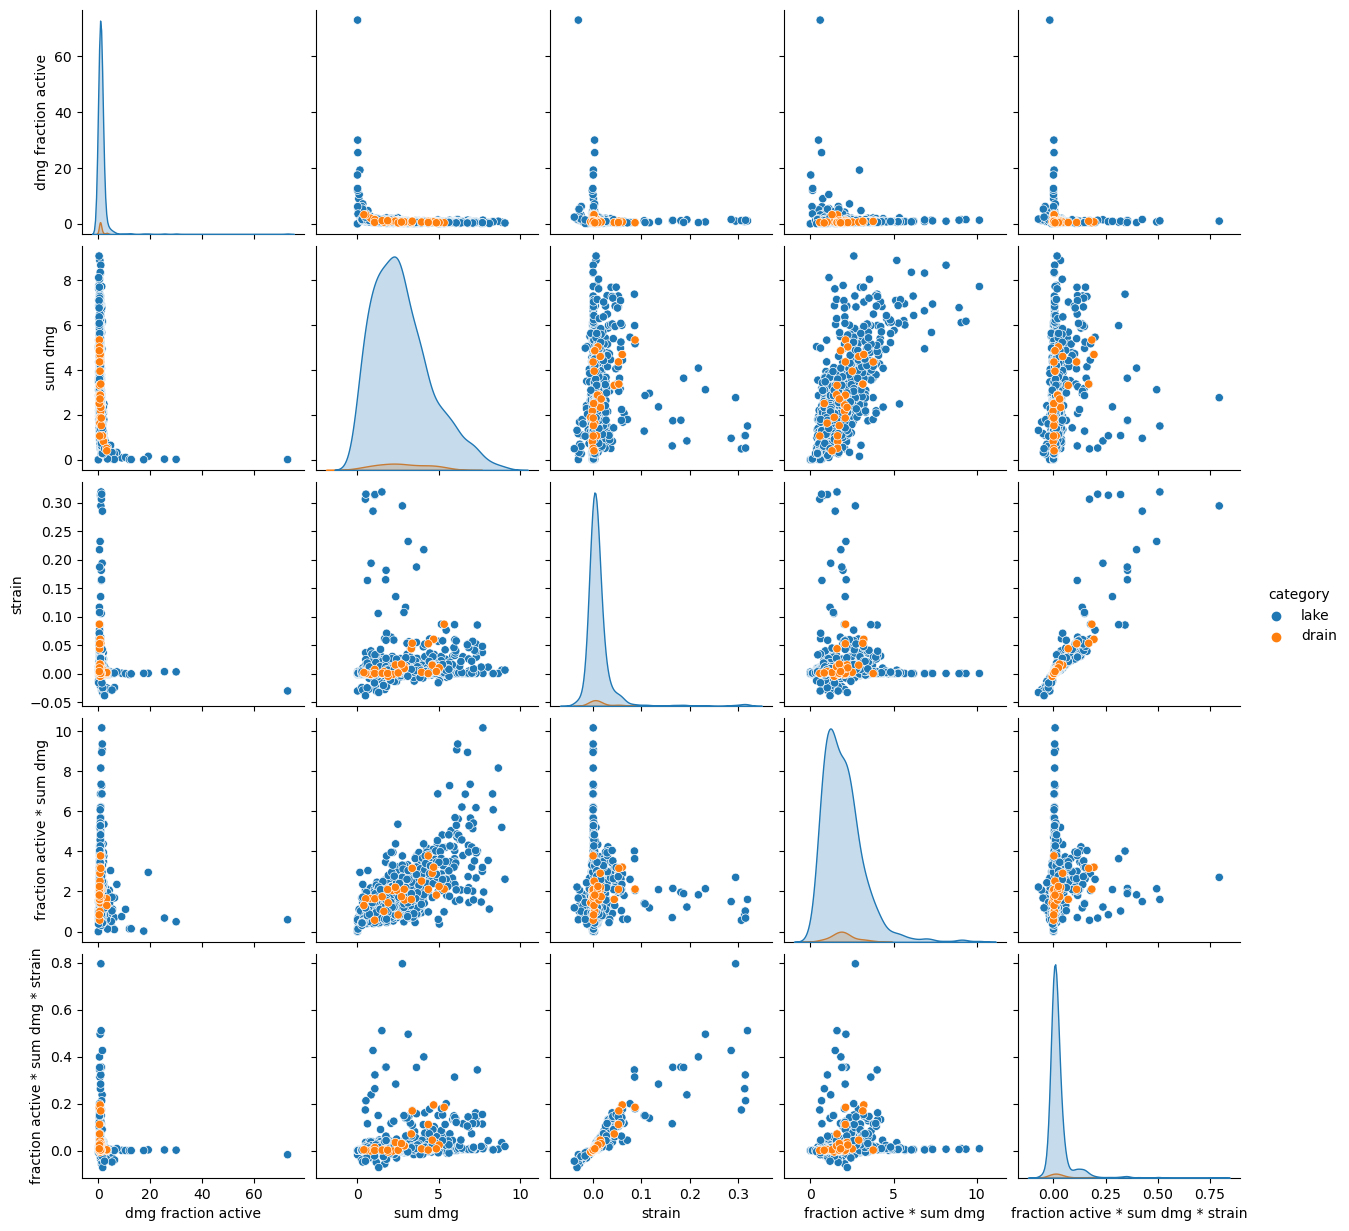

In [35]:
sns.pairplot(combined[["dmg fraction active", "sum dmg", "strain", "fraction active * sum dmg", "fraction active * sum dmg * strain", "category"]], hue = "category")
plt.show()